In [1]:
%pylab inline
data = sc.textFile("weatherAUS1.csv")
header = data.first() #extract header
print(header)
data = data.filter(lambda row : row != header)

Populating the interactive namespace from numpy and matplotlib


Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow


In [2]:
class HeadersName:
    def __init__(self):
        self.headers = dict()
        self.values = []
    def add_headers(self,key,value):
        self.headers[key] = value
    def get_header(self,key):
        return self.headers[key]
    def get_all_values(self):
        self.values =  list(self.headers.values())
        return self.values 
    def get_index_from_key(self,key):
        index_in_header = self.get_header(key)
        return self.values.index(index_in_header)
    
headers_fields = header.split(",")
headerName = HeadersName()
headerName.add_headers('WindGustSpeed',headers_fields.index('WindGustSpeed'))
headerName.add_headers('WindSpeed9am',headers_fields.index('WindSpeed9am'))
headerName.add_headers('Humidity9am',headers_fields.index('Humidity9am'))
headerName.add_headers('Pressure9am',headers_fields.index('Pressure9am'))
headerName.add_headers('Temp9am',headers_fields.index('Temp9am'))

In [3]:
baseData = data.zipWithUniqueId().map(lambda line: (line[-1],line[:-1][0].split(",")))

In [4]:
import math
class HandleData():
    def __init__(self,headerName):
        self.rows = headerName.get_all_values()
        self.lb = self.builder(self.listbuiler) 
        self.fb = self.builder(self.filterbuiler)

    def builder(self,fu):
        return fu(self.rows)
    
    def isNotANumber(self,s):
        try:
            if(math.isnan(self.num(s))):
                return True
        except:
            return True
        
        return False
    
    def num(self,s):
        try:
            return int(s)
        except ValueError:
            return float(s)
        
    def listbuiler(self,rows):
        def getUniqueRow(line,uniqueid,appendOnlyNum=True):
            items = []
            for row in rows:
                if appendOnlyNum:
                    item = self.num(line[row])
                else:
                    item = line[row]
                items.append(item)
            return (uniqueid,items)
        return getUniqueRow

    def filterbuiler(self,rows):
        def filterNan(line):
            for row in rows:
                try:
                    if(math.isnan(self.num(line[row]))):
                        return False
                except:
                    print('excption catch')
                    return False
            return True
        return filterNan
    
hd = HandleData(headerName)


In [5]:

filteredByColumn = baseData.filter(lambda line: hd.fb(line[1])).map(lambda line: hd.lb(line[1],line[0]))

def distinctAndCount(filteredByColumn,headerName,key):
    return filteredByColumn.map(lambda pair: pair[1][headerName.get_index_from_key(key)]).distinct().count()

WindSpeed9amCount= distinctAndCount(filteredByColumn,headerName,'WindSpeed9am')
WindGustSpeedCount= distinctAndCount(filteredByColumn,headerName,'WindGustSpeed')
Humidity9amCount= distinctAndCount(filteredByColumn,headerName,'Humidity9am')
Pressure9amCount= distinctAndCount(filteredByColumn,headerName,'Pressure9am')
Temp9amCount= distinctAndCount(filteredByColumn,headerName,'Temp9am')

print('WindSpeed9amCount:{} ,WindGustSpeedCount:{} , Humidity9amCount :{},Pressure9amCount :{} Temp9amCount :{}'.format(WindSpeed9amCount,WindGustSpeedCount,Humidity9amCount,Pressure9amCount,Temp9amCount))


WindSpeed9amCount:40 ,WindGustSpeedCount:67 , Humidity9amCount :101,Pressure9amCount :545 Temp9amCount :400


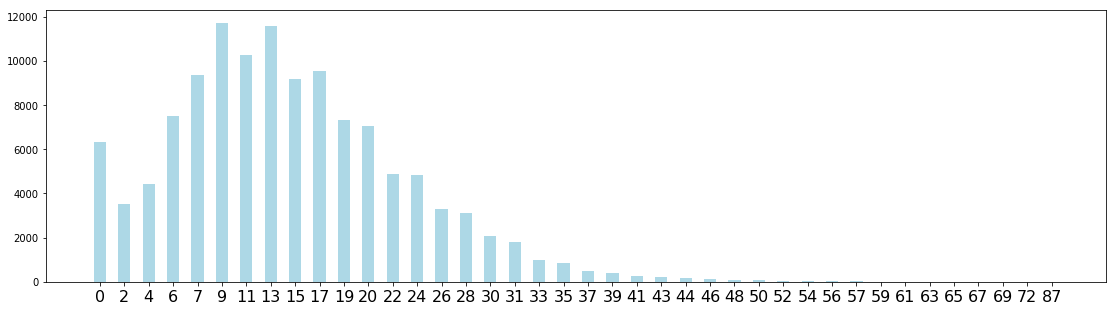

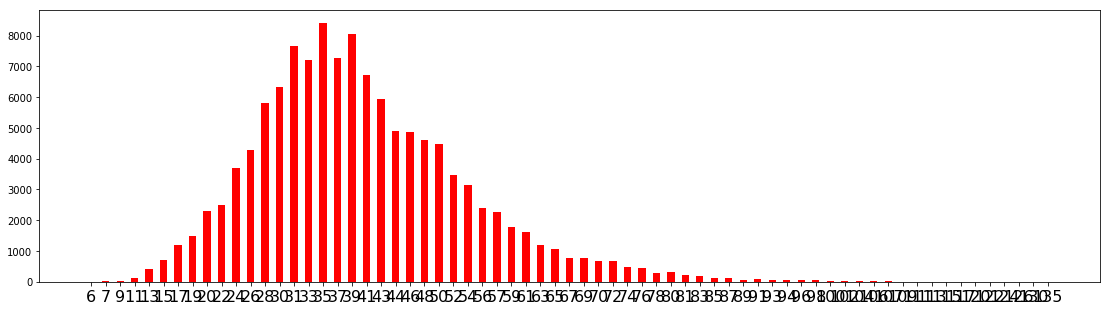

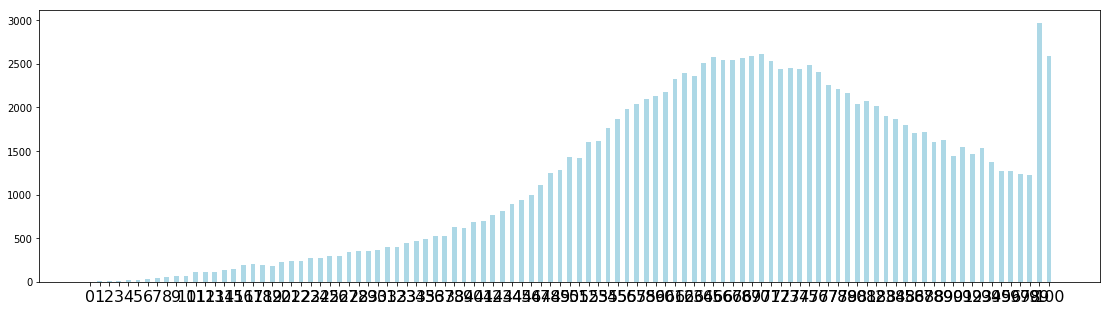

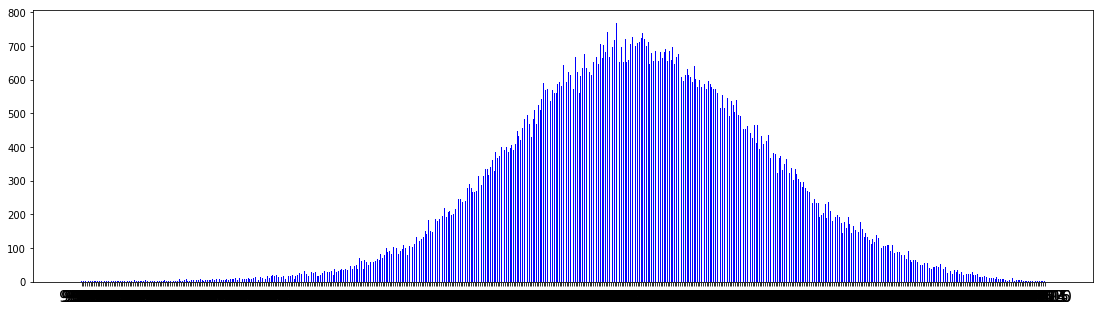

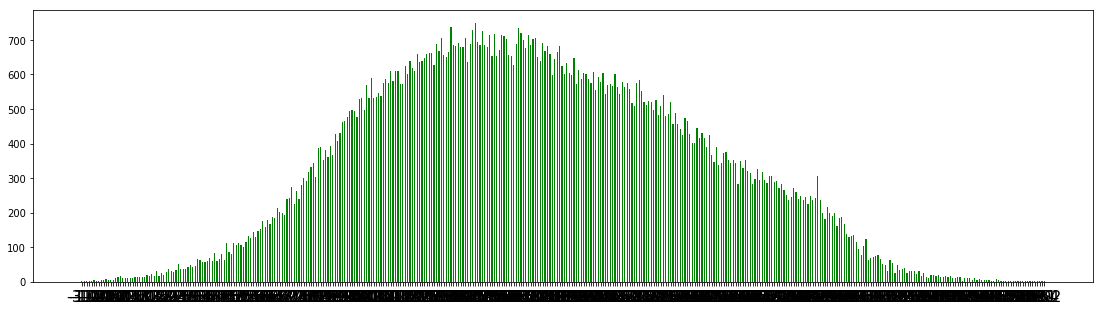

In [6]:
class Drawer():
    @staticmethod
    def countAggregateByKey(rddColumn):
        aggragateByKey = rddColumn.countByValue() 

        keys  = aggragateByKey.keys()
        x_axis = np.array(sorted(keys))
        y_axis = np.array([aggragateByKey.get(key) for key in x_axis])
        return Drawer.buildObj(x_axis,y_axis)
    
    @staticmethod
    def buildObj(x_axis,y_axis):
        res = dict()
        res['x'] = {
            'pos': np.arange(len(x_axis)),
            'x_axis':x_axis
        }
        res['y']={
            'y_axis':y_axis
        }
        return res
    
    @staticmethod
    def _draw_histo(obj,color):
        y_axis = obj['y']['y_axis']
        pos = obj['x']['pos']
        x_axis = obj['x']['x_axis']

        ax = plt.axes()
        ax.set_xticks(pos)
        ax.set_xticklabels(x_axis)

        plt.bar(pos, y_axis, 0.5, color=color)
        plt.xticks(size=16)

        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(19, 5)
        plt.show()
    
    @staticmethod
    def drow(rddColumn,color):
        obj = Drawer.countAggregateByKey(rddColumn)
        Drawer._draw_histo(obj,color)
        
def filterColumnByHeader(filteredByColumn,headerName,key):
    return filteredByColumn.map(lambda pair: pair[1][headerName.get_index_from_key(key)])


    
x_y_WindSpeed9am = filterColumnByHeader(filteredByColumn,headerName,'WindSpeed9am')
Drawer.drow(x_y_WindSpeed9am,'lightblue')
x_y_WindGustSpeed = filterColumnByHeader(filteredByColumn,headerName,'WindGustSpeed')
Drawer.drow(x_y_WindGustSpeed,'red')
x_y_Humidity9am = filterColumnByHeader(filteredByColumn,headerName,'Humidity9am')
Drawer.drow(x_y_Humidity9am,'lightblue')
x_y_Pressure9am = filterColumnByHeader(filteredByColumn,headerName,'Pressure9am')
Drawer.drow(x_y_Pressure9am,'blue')
x_y_Temp9am = filterColumnByHeader(filteredByColumn,headerName,'Temp9am')
Drawer.drow(x_y_Temp9am,'green')



In [7]:
class DataRecoveryModel():
    def __init__(self,v,sigma,median):
        items = dict()
        items['normal'] = {'mu':v[0]/v[1],'sigma':sigma }
        items['median'] = median
        self.items = items
    def getByType(self,_type):
        return self.items[_type]

    

class DataRecoveryService():
    def __init__(self,baseData,headerName):
        self.headerName = headerName
        self.items = dict()
        hd = self.hd = HandleData(headerName)
        self.shrinkTableAndDarity = baseData.map(lambda line: hd.lb(line[1],line[0],False))                   
        self.filteredByColumn = baseData.filter(lambda line: hd.fb(line[1]))\
            .map(lambda line: hd.lb(line[1],line[0]))
          
    def fixByType(self,typeFixer,cloumnName):
        dataRecoveryModel = self.items[cloumnName]      
        if typeFixer == 'mean':
            metadata = dataRecoveryModel.getByType('normal')
            return metadata['mu']
        elif typeFixer == 'median':
            return dataRecoveryModel.getByType('median')
        else:
            return 0
        
    
    def findTheMidle(self,NumOfVal):
        if NumOfVal % 2!= 0:
            NumOfVal = NumOfVal +1
        return NumOfVal/2
    
    def calcDataRecoveryTypes(self,columnName):
        hd = self.hd
        headerName = self.headerName
        v = self.filteredByColumn.map(lambda pair: (pair[1][headerName.get_index_from_key(columnName)],1))\
                            .reduce(lambda a,b: (a[0]+b[0],a[1]+b[1]))
        n = self.findTheMidle(v[1])
        median = self.filteredByColumn.map(lambda pair: (pair[1][headerName.get_index_from_key(columnName)]))\
                            .sortBy(lambda item :item).zipWithIndex().filter(lambda pair : pair[1] == n).collect()[0][0]
        self.items[columnName] = DataRecoveryModel(v,1,median)
        
    
    
    def normelizeColumn(self,cloumnName,sigma):
        dataRecoveryModel = self.items[cloumnName]
        metadata = dataRecoveryModel.getByType('normal')
        mu =  metadata['mu']
        return self.filteredByColumn.\
            map(lambda pair: normalizeFixer(pair[1][headerName.get_index_from_key(cloumnName)],mu,sigma))

    
    
    def fixCellsByType(self,typeFixer,columnName):
        fixedValue = self.fixByType(typeFixer,columnName)
        hd = self.hd
        return self.shrinkTableAndDarity.\
            map(lambda pair: fixCellsByTypePrivate(pair[1][headerName.get_index_from_key(columnName)],fixedValue,hd))

def normalizeFixer(X,mu,sigma):
    return (X - mu)/sigma    
    
def fixCellsByTypePrivate(cell,fixedValue,hd):
    isNotANumber = hd.isNotANumber(cell)
    if isNotANumber :
        cell = fixedValue
    else: 
        cell = hd.num(cell)
    return cell                               

In [8]:
DRService = DataRecoveryService(baseData,headerName)
DRService.calcDataRecoveryTypes('WindGustSpeed')
DRService.calcDataRecoveryTypes('WindSpeed9am')
DRService.calcDataRecoveryTypes('Humidity9am')
DRService.calcDataRecoveryTypes('Pressure9am')
DRService.calcDataRecoveryTypes('Temp9am')


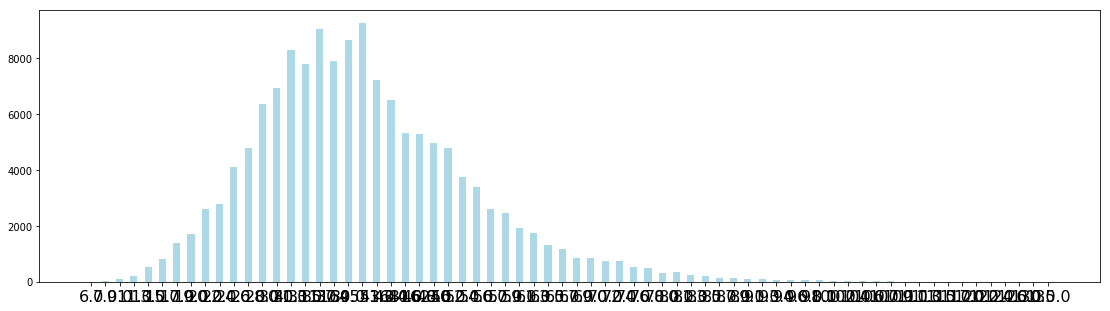

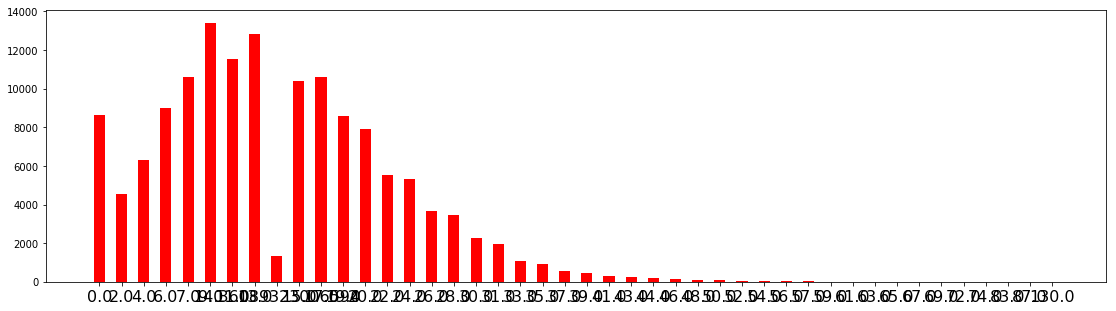

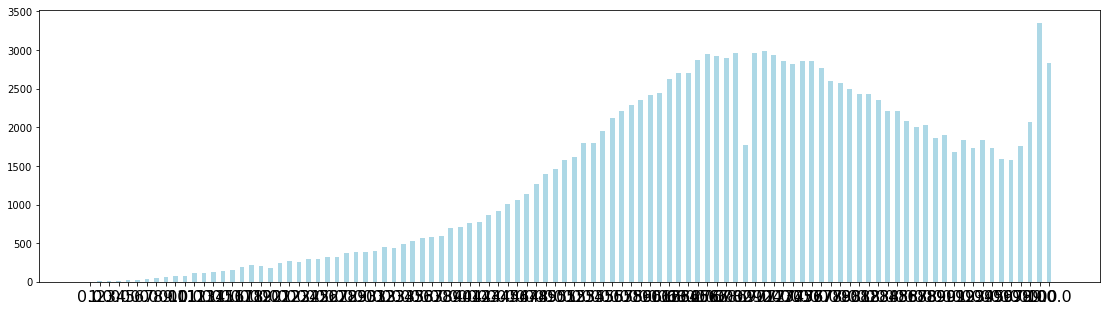

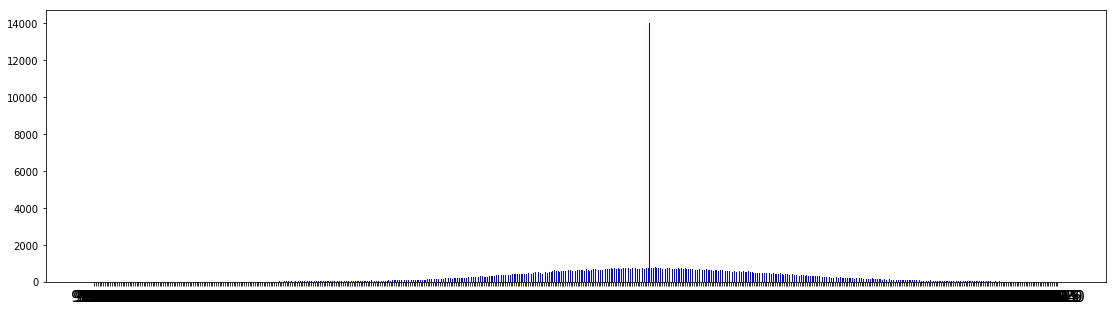

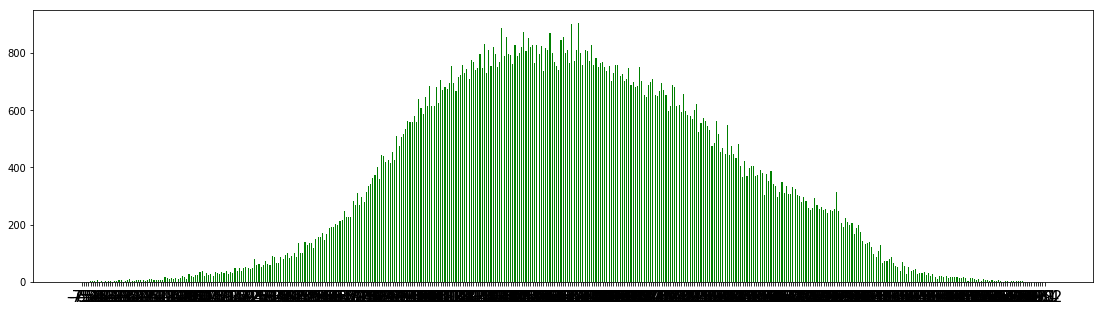

In [9]:
Drawer.drow(DRService.fixCellsByType('mean','WindGustSpeed'),'lightblue')
Drawer.drow(DRService.fixCellsByType('mean','WindSpeed9am'),'red')
Drawer.drow(DRService.fixCellsByType('mean','Humidity9am'),'lightblue')
Drawer.drow(DRService.fixCellsByType('mean','Pressure9am'),'blue')
Drawer.drow(DRService.fixCellsByType('mean','Temp9am'),'green')

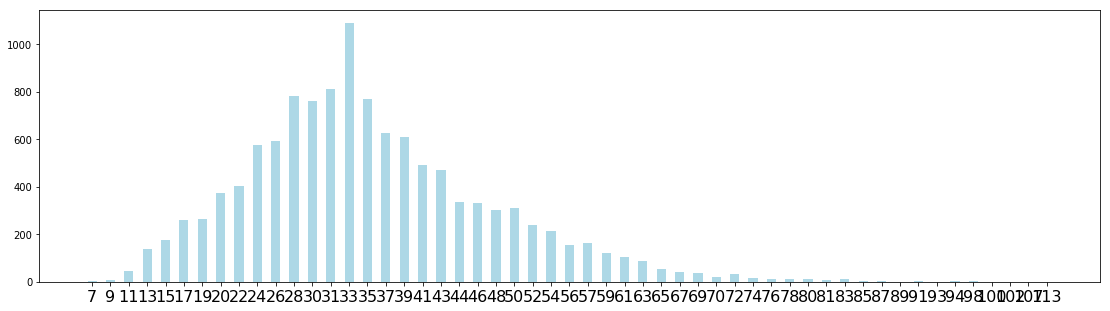

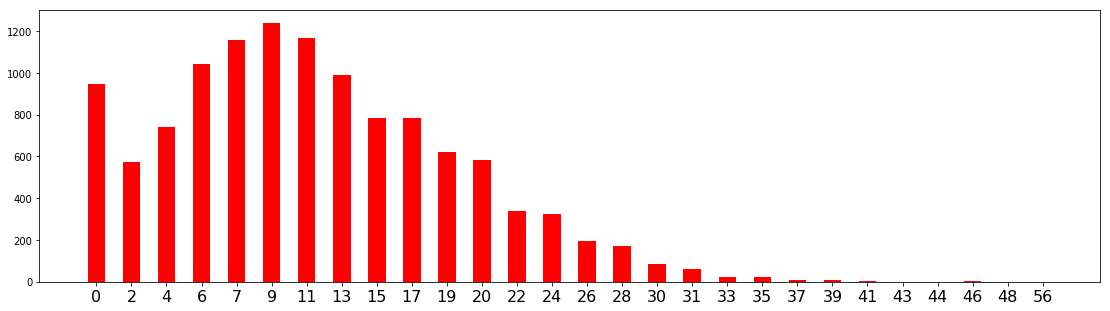

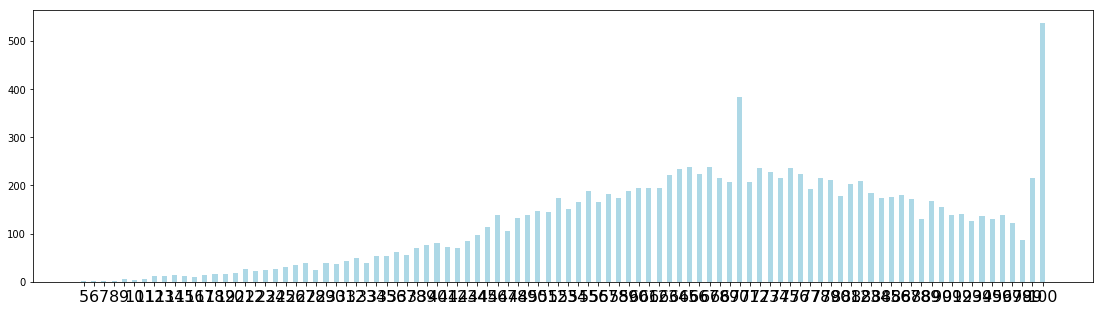

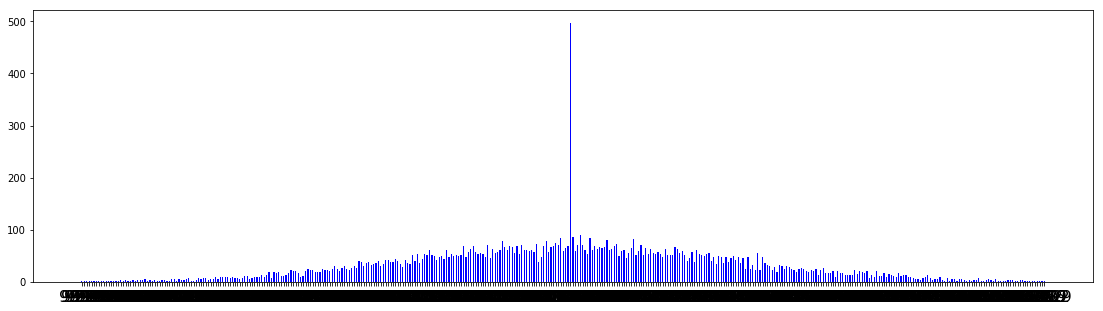

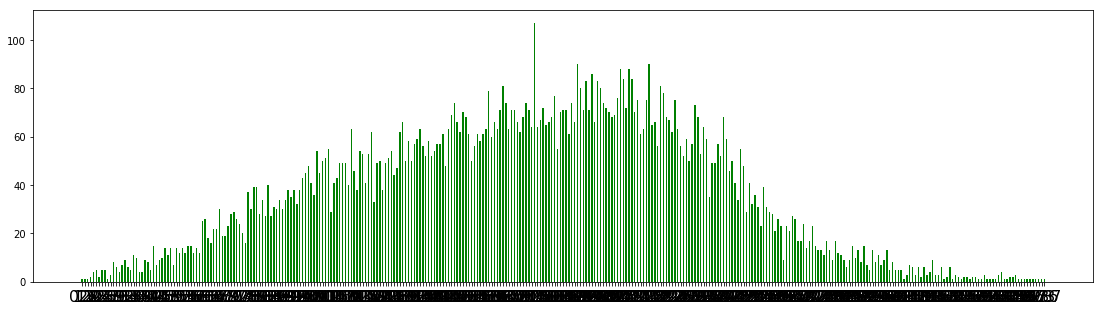

In [ ]:
Drawer.drow(DRService.fixCellsByType('median','WindGustSpeed'),'lightblue')
Drawer.drow(DRService.fixCellsByType('median','WindSpeed9am'),'red')
Drawer.drow(DRService.fixCellsByType('median','Humidity9am'),'lightblue')
Drawer.drow(DRService.fixCellsByType('median','Pressure9am'),'blue')
Drawer.drow(DRService.fixCellsByType('median','Temp9am'),'green')

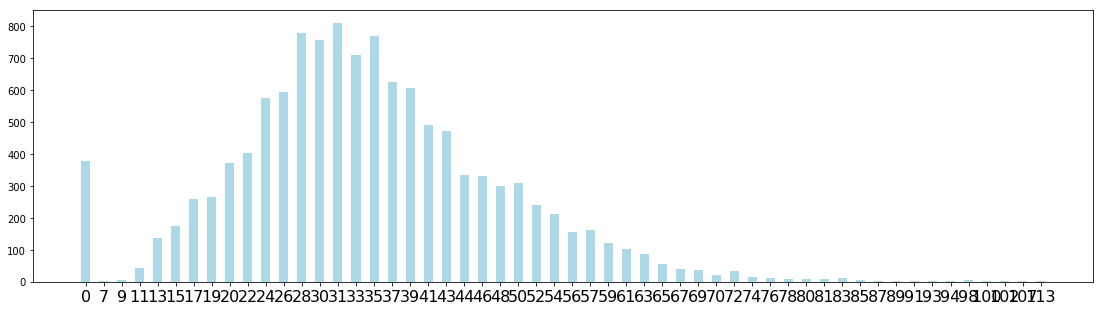

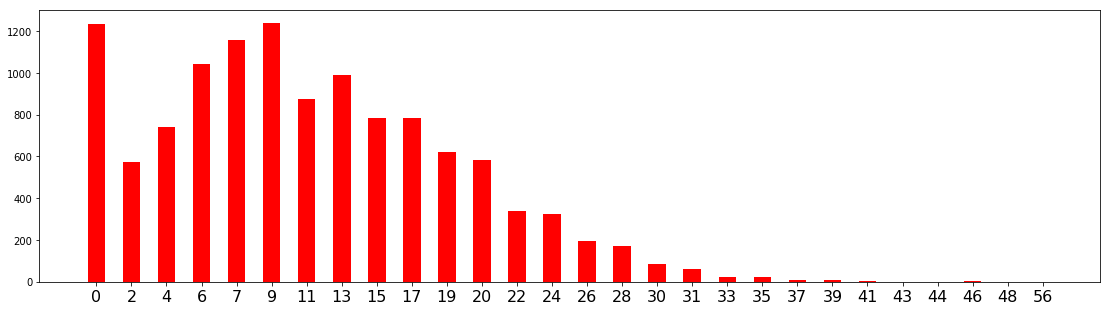

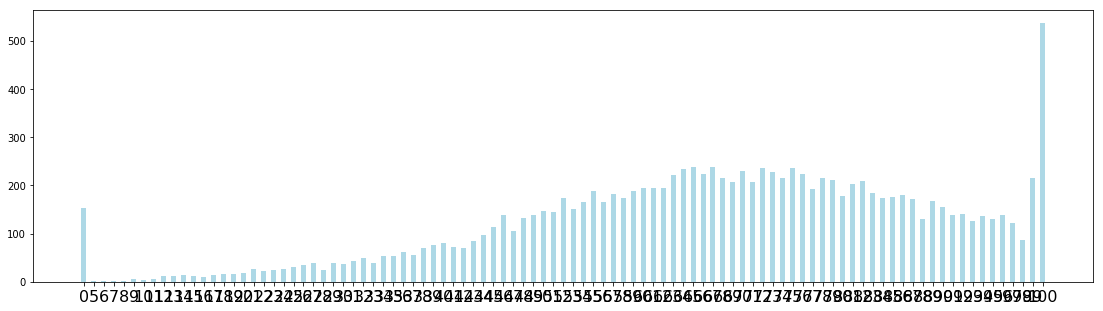

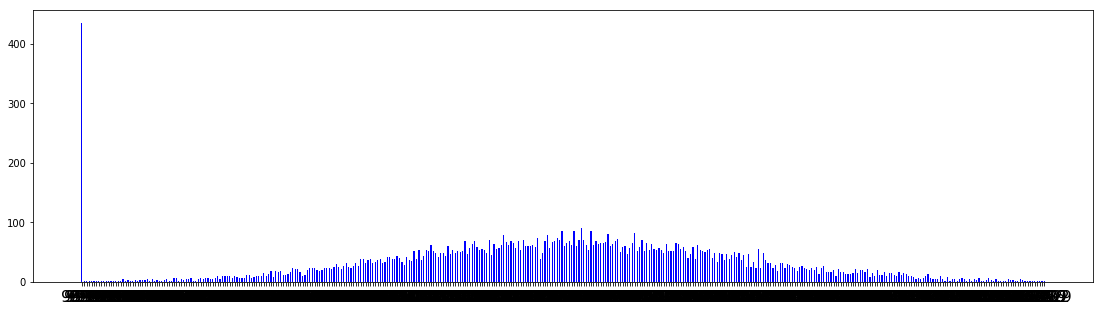

In [ ]:
Drawer.drow(DRService.fixCellsByType('zero','WindGustSpeed'),'lightblue')
Drawer.drow(DRService.fixCellsByType('zero','WindSpeed9am'),'red')
Drawer.drow(DRService.fixCellsByType('zero','Humidity9am'),'lightblue')
Drawer.drow(DRService.fixCellsByType('zero','Pressure9am'),'blue')
Drawer.drow(DRService.fixCellsByType('zero','Temp9am'),'green')

In [ ]:
Drawer.drow(DRService.normelizeColumn('Pressure9am',sigma = 4,),'blue')
Drawer.drow(DRService.normelizeColumn('Temp9am',sigma = 4,),'green')

In [ ]:
class CategoryService():
    def __init__(self,headerName):
        items = dict()
        self.items = items
        self.headerName = headerName
        self.Columns = []
        self.CleanColumns = shrinkTableCategory.filter(lambda x:CleanLineWithValue(x,'NA')) 
    
        def CleanLineWithValue(Row,StringToClean):
            ListofValues = Row[1]
            for i in ListofValues: 
                if i == StringToClean: 
                    return(False)
            return(True) 

    def ChengeTheCategoryValues(self):
        ColumnsNum = self.CleanColumns.map(lambda Row: Row[1])
        categToNum = self.items
        numTable = ColumnsNum.map(lambda x: performtheMap(x,categToNum))
        tableWithID = numTable.zipWithUniqueId().map(lambda x: (x[1],x[0]))
        return(tableWithID)
        
    def createMapCategoryForCol(self,nameOfCol):
        headerName = self.headerName
        spacificColumn = self.CleanColumns.map(lambda x: GetSpacificColumn(x,nameOfCol,headerName))
        ReduceKey = spacificColumn.map(lambda x: (x,1)).reduceByKey(add).map(lambda x: x[0]).collect()
        self.items[headerName.get_index_from_key(nameOfCol)] = ReduceKey
         
    def SplitTheDateColumn(self,nameOfCol):
        headerName = self.headerName
        CleanColumns = self.CleanColumns
        TheFixTable = CleanColumns.map(lambda x: ReplaceTheColumnSplited(x,nameOfCol,headerName))
        FixTableID = TheFixTable.zipWithUniqueId().map(lambda x: (x[1],(x[0])[1]))
        return(FixTableID)
    
def performtheMap(Row,categToNum):
    num = 0
    for i in Row:
        indexOfNumValue = categToNum[num].index(i)
        Row[num]=indexOfNumValue
        num = num +1
    return(Row)

def GetSpacificColumn(Row,NameOfColumn,headerName):
    Index = headerName.get_index_from_key(NameOfColumn)
    ValuCol = Row[1] 
    return(ValuCol[Index])
        
def ReplaceTheColumnSplited(Row,NameOfColumn,headerName):
    Index = headerName.get_index_from_key(NameOfColumn)
    ValuCol = Row[1] 
    SplitededCol = ValuCol[Index].split("/") 
    FixTable = (Row[0],ValuCol[0:Index] + SplitededCol + ValuCol[Index+1:]) 
    return(FixTable)

In [ ]:
headerNameCategory = HeadersName()
headerNameCategory.add_headers('WindDir3pm',headers_fields.index('WindDir3pm'))
headerNameCategory.add_headers('WindDir9am',headers_fields.index('WindDir9am'))
hdCategory = HandleData(headerNameCategory)
shrinkTableCategory = baseData.map(lambda line: hdCategory.lb(line[1],line[0],False))

CategoryServiceObject = CategoryService(headerNameCategory)
CategoryServiceObject.createMapCategoryForCol('WindDir9am')
CategoryServiceObject.createMapCategoryForCol('WindDir3pm')
FixedTable = CategoryServiceObject.ChengeTheCategoryValues()

FixedTable.take(50)


In [ ]:
ChengeTheTimeStamp = HeadersName()
#For the example i choose some Columns - we can choose witch columns we want
ChengeTheTimeStamp.add_headers('Location',headers_fields.index('Location'))
ChengeTheTimeStamp.add_headers('Date',headers_fields.index('Date'))
ChengeTheTimeStamp.add_headers('MaxTemp',headers_fields.index('MaxTemp'))
ChengeTheTimeStamp.add_headers('Rainfall',headers_fields.index('Rainfall'))

TimeStampHD = HandleData(ChengeTheTimeStamp)
shrinkTableCategory = baseData.map(lambda line: TimeStampHD.lb(line[1],line[0],False))
TimeStampServiceObject = CategoryService(ChengeTheTimeStamp)
FIxedTable = TimeStampServiceObject.SplitTheDateColumn('Date')

FIxedTable.take(30)